# library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

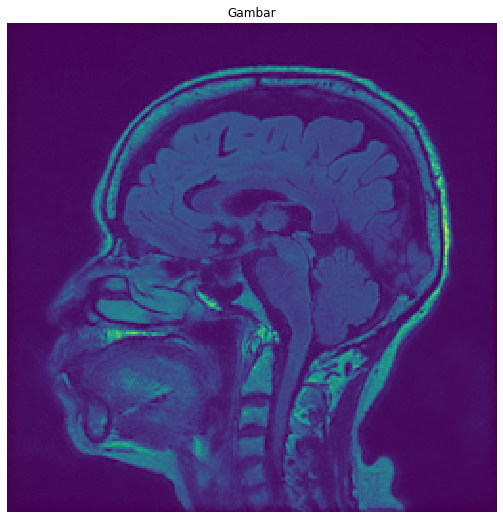

In [4]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z519")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [5]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Otsu thresholding

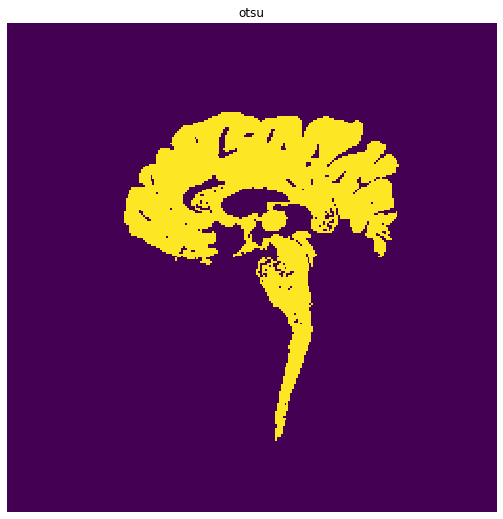

In [7]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask_binarized = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
otsu = np.zeros_like(binarized)
otsu[labels == largest_label] = foreground_value
ShowImage('otsu',otsu,'rgb')

# Invers dari Otsu

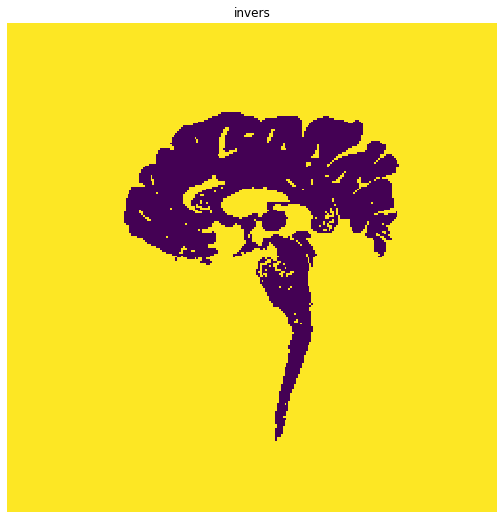

In [8]:
invers = cv2.bitwise_not(otsu)
ShowImage('invers',invers,'rgb')

# Dilation from Otsu

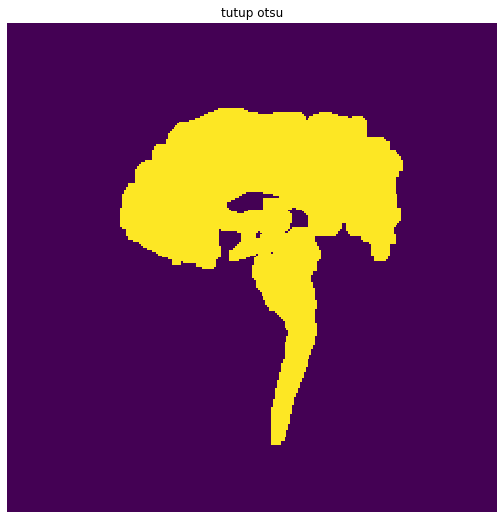

In [9]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(otsu,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_otsu = np.zeros_like(dilasi)
tutup_otsu[labels == largest_label] = foreground_value
ShowImage('tutup otsu',tutup_otsu,'rgb')


# Dilation from otsu_invers

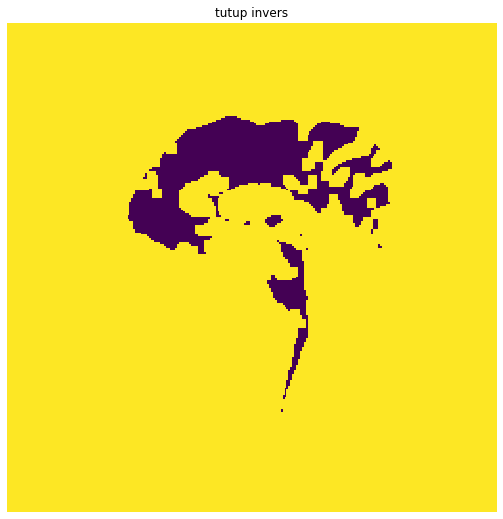

In [10]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(invers,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# tophat dari opening

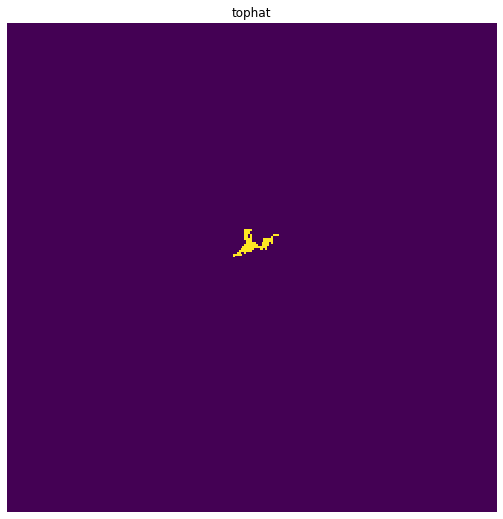

In [11]:
# tophat
kernel = np.ones((5, 5), np.uint8)
tophat = cv2.morphologyEx(otsu, cv2.MORPH_TOPHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(tophat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
top = np.zeros_like(tophat)
top[labels == largest_label] = foreground_value
ShowImage('tophat',top,'rgb')

# tophat dari invers

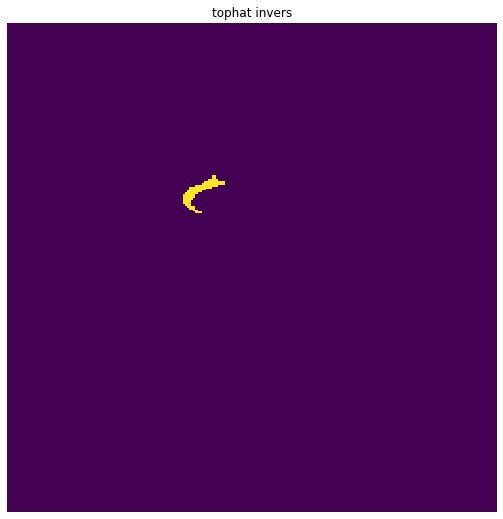

In [12]:
# tophat
kernel = np.ones((5, 5), np.uint8)
tophat = cv2.morphologyEx(invers, cv2.MORPH_TOPHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(tophat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
top_invers = np.zeros_like(tophat)
top_invers[labels == largest_label] = foreground_value
ShowImage('tophat invers',top_invers,'rgb')

# Dilation from tophat_otsu

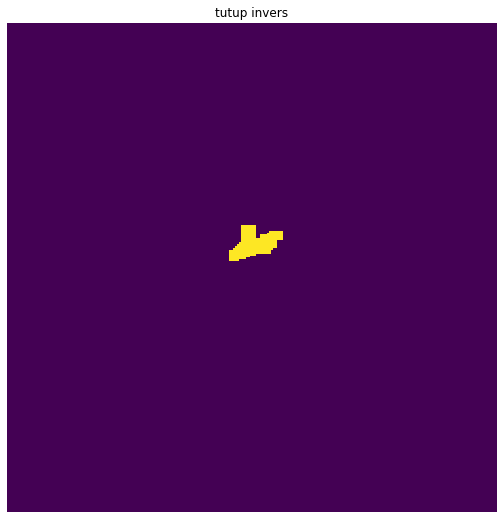

In [13]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(top,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# Dilation from tophat_invers

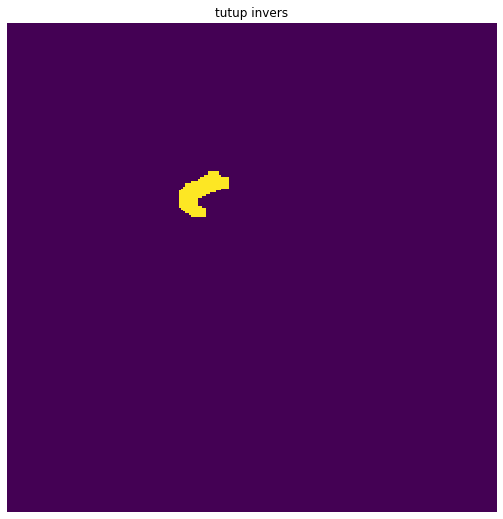

In [14]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(top_invers,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# Skull Stripping

In [15]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = tutup_invers)
brain_pixels = skull_stripped_image[tutup_invers == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[59 65 69 75 66 70 66 75 68 52 59 68 65 64 73 70 30 17 55 70 64 65 66 69
 71 68 45 15 18 61 70 67 63 63 66 67 76 74 76 71 61 38 18 13 23 35 44 52
 62 63 65 65 68 64 63 73 79 87 75 30 16  9  7 20 19 16 20 22 38 40 47 51
 64 66 67 66 69 63 51 41 45 26  3 10 12 14 18 17 23 26 34 38 38 47 53 62
 69 78 64 50 31  8  5 11  9 18 19 16 19 21 28 36 46 51 47 45 49 57 72 81
 71 39 23 14  4  9 11 19 17 21 26 31 38 41 44 47 47 41 38 44 44 47 70 77
 73 41  9 11  9 15 14 22 20 26 40 47 47 52 49 45 43 43 45 69 77 78 42 19
 28 24 14 19 23 26 34 46 50 50 47 47 44 40 62 70 46  9 10 18 14 17 26 32
 43 45 47 44 41 46 65 58 28 18 24 22 17 20 42 49 47 37 39 47 73 50  7 23
 20 15 23 36 58 51 46 45 75 56  2 14 20 17 31 52 57 43 79 64 15 14 16 22
 44 52 48 45 71 55 27 16 15 20 42 50 45 49 67 57 52 30 12  9 41 54 43 37
 67 66 71 50 18 11 17 40 44 36 39 37 70 72 65 52 35 17 18 45 46 46 39 37
 39 65 73 74 64 56 30 23 34 45 46 42 41 66 68 68 73 56 39 34 33 39 47 46
 63 67 66 64 65 60 55 56 54 64 63 64 64 65 62 60 61

# Segmented image

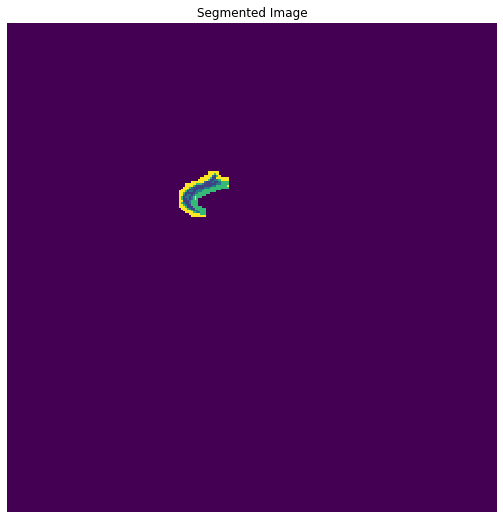

In [16]:
segmented_image = np.zeros_like(tutup_invers)
segmented_image[tutup_invers == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

# All in One Row

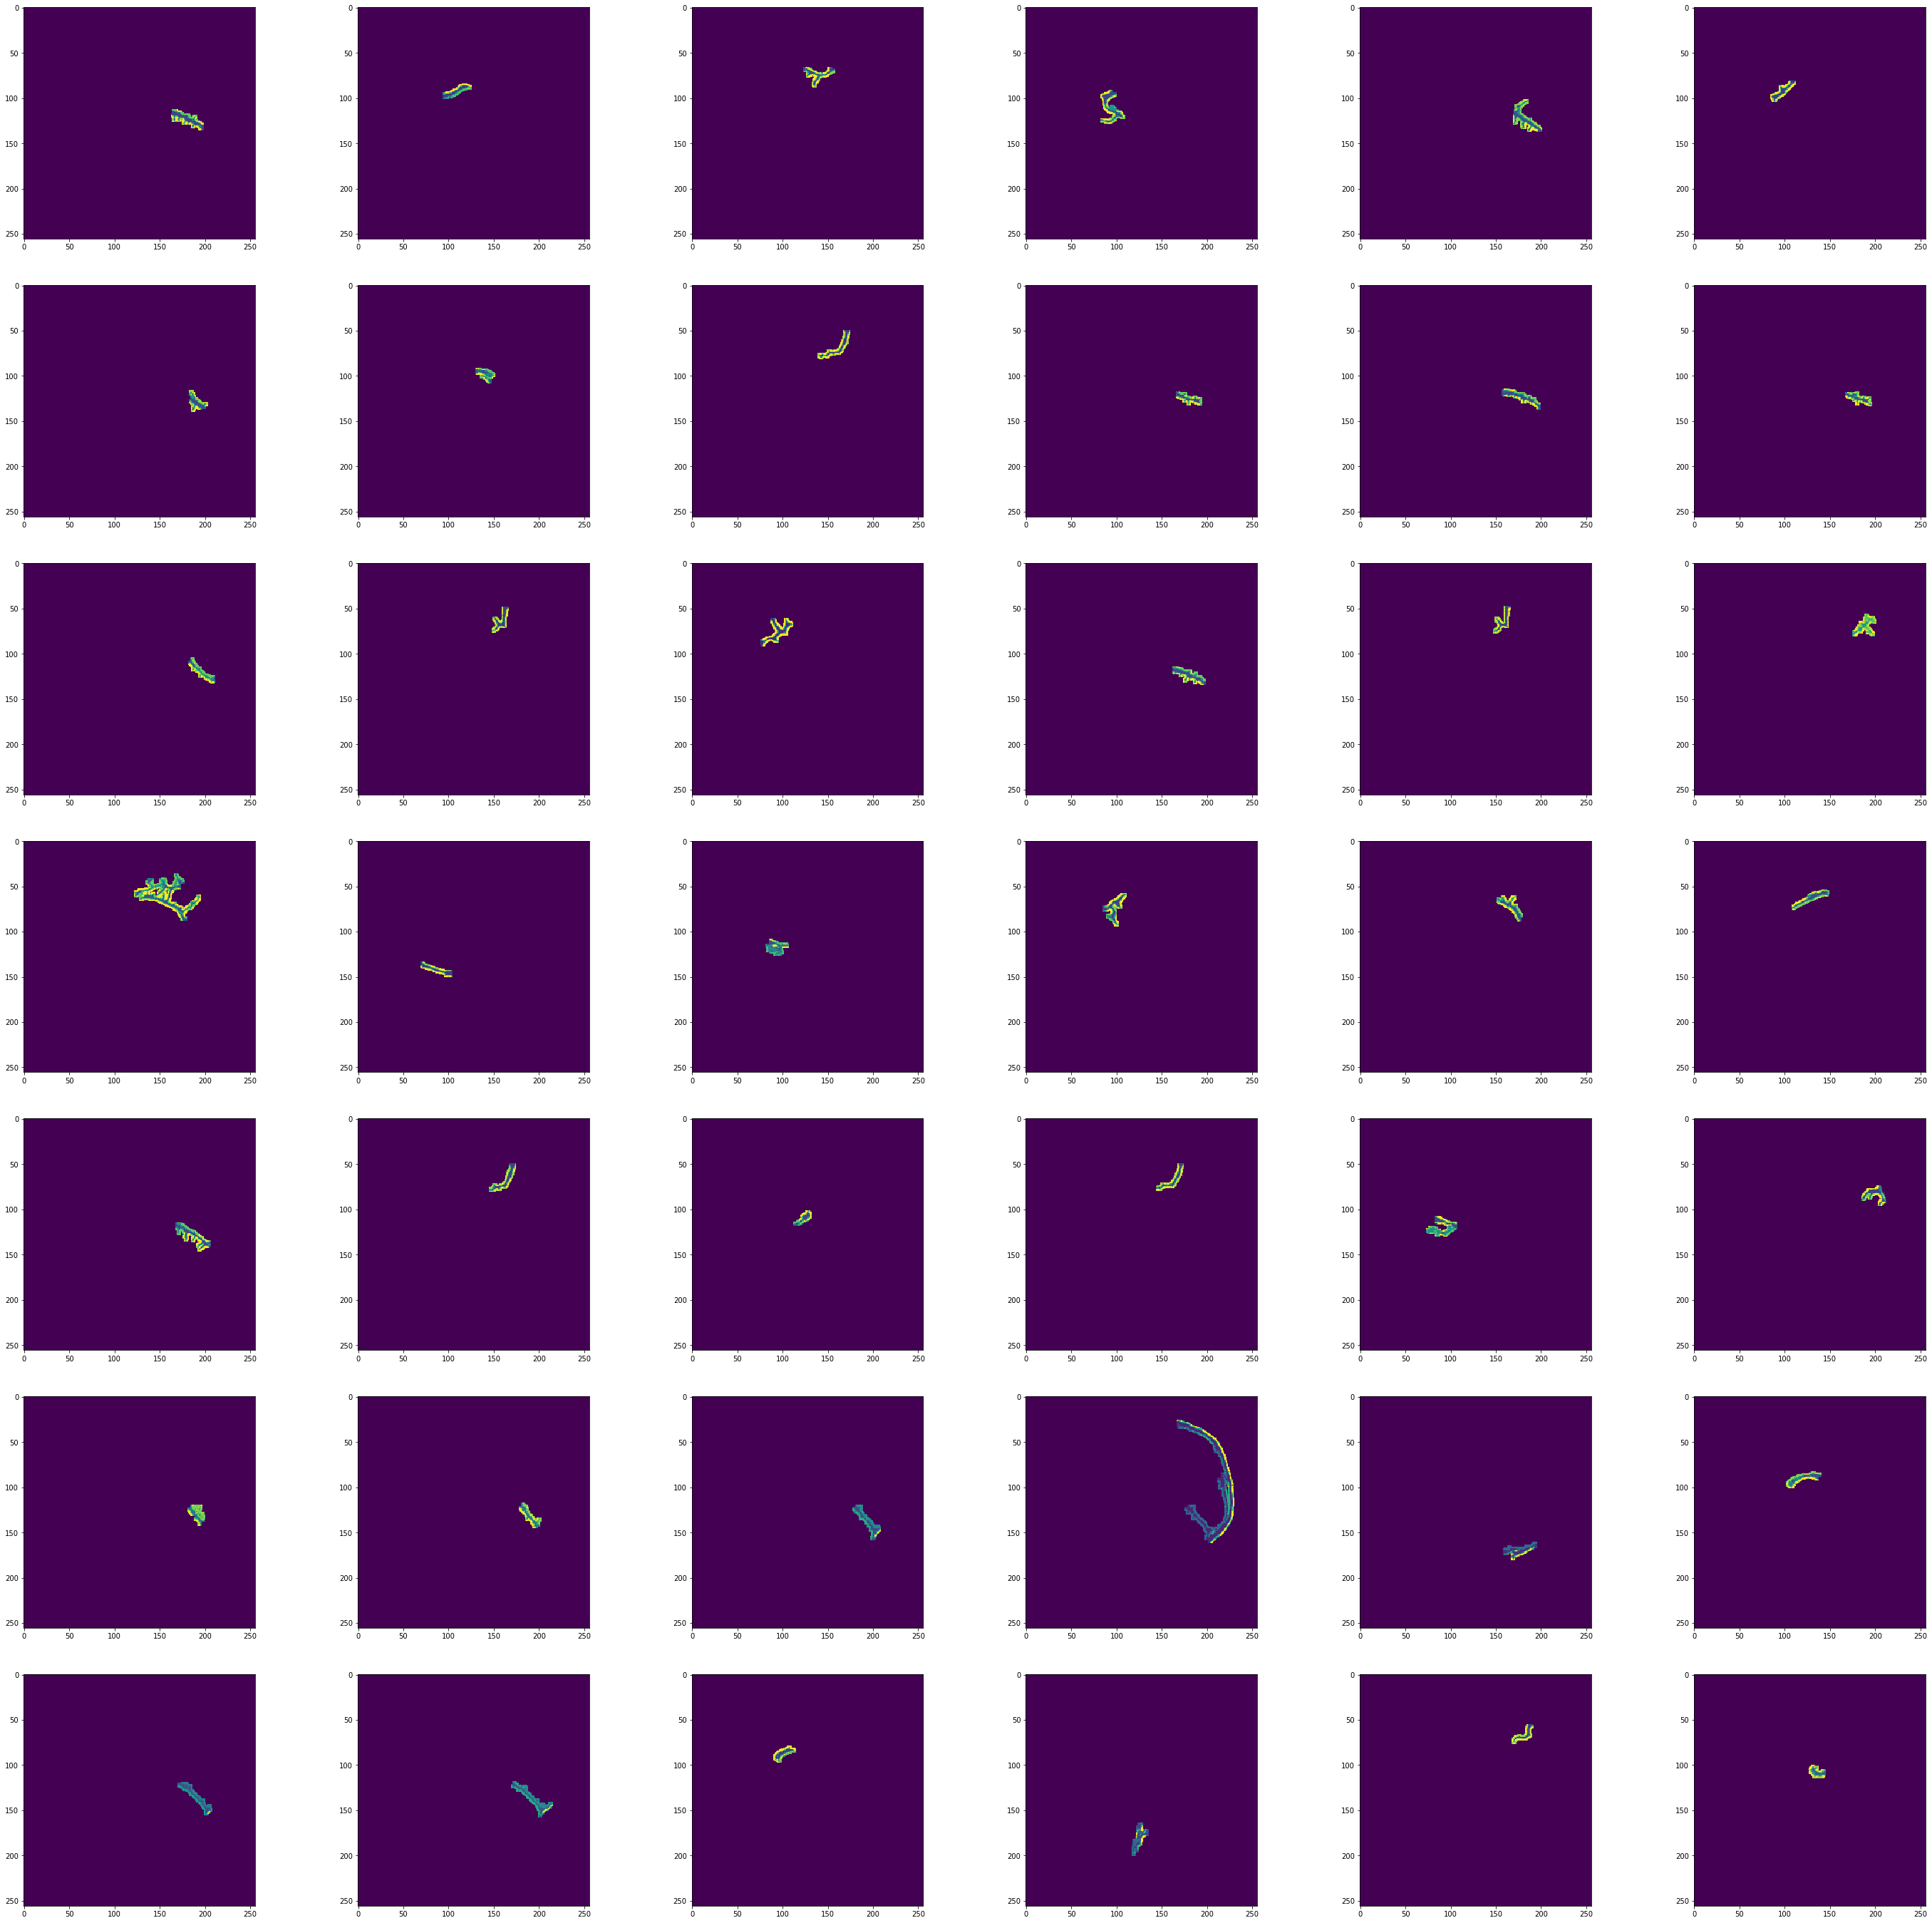

In [27]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    foreground_value = 255
    mask_binarized = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    otsu = np.zeros_like(binarized)
    otsu[labels == largest_label] = foreground_value
    
    invers = cv2.bitwise_not(otsu)
    
    bentukan = np.ones((5, 5), np.uint8)
    dilasi = cv2.dilate(invers,bentukan,iterations = 1)

    foreground_value = 255
    mask_dilasi = np.uint8(dilasi >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    tutup_invers = np.zeros_like(dilasi)
    tutup_invers[labels == largest_label] = foreground_value
    
    # tophat
    kernel = np.ones((5, 5), np.uint8)
    tophat = cv2.morphologyEx(invers, cv2.MORPH_TOPHAT, kernel)

    foreground_value = 255
    mask_gradient = np.uint8(tophat == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    top_invers = np.zeros_like(tophat)
    top_invers[labels == largest_label] = foreground_value
    
    bentukan = np.ones((5, 5), np.uint8)
    dilasi = cv2.dilate(top_invers,bentukan,iterations = 1)
    
    foreground_value = 255
    mask_dilasi = np.uint8(dilasi >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    tutup_invers = np.zeros_like(dilasi)
    tutup_invers[labels == largest_label] = foreground_value

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = tutup_invers)
    brain_pixels = skull_stripped_image[tutup_invers == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(tutup_invers)
    segmented_image[tutup_invers == foreground_value] = labels
    
    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()